### Biased Mean Variance Objective with Elastic Net Penalty Solved via Split Bregman 


In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds, LinearConstraint
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

path='/home/jbohn/jupyter/personal/L1_Portfolio_Opt'
sys.path.append(path)

from Features.features import load_features
from Parameter_Estimation.bias_mean import reg_mean
from Parameter_Estimation.bias_cov import reg_cov

### Prep and Load Equity Data 

In [2]:
train_data,test_data=load_features(0.5)
train_data

,MMM,AOS,ABT,ABMD,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WHR,WMB,WTW,GWW,WYNN,XEL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.628321,-1.285971,-0.811210,-2.432083,0.616121,0.176830,0.538743,1.631272,-0.538452,-0.596131,...,-0.207657,1.241682,-0.224387,0.041128,5.904149,-1.193047,-0.342566,-0.174548,3.116535,3.465148
2010-01-06,1.408218,0.045393,0.553813,-1.535767,1.057458,-0.531440,-0.253164,-0.212432,-0.235015,0.868174,...,-0.884311,3.193428,1.597067,0.379627,-1.320395,0.191851,-0.717461,-0.771667,-0.032304,8.338160
2010-01-07,0.071691,0.294622,0.825011,0.000000,-0.093539,-2.427090,-1.051132,-1.959530,-0.047069,-0.024706,...,2.123851,-0.710789,-0.295205,0.937728,2.113119,-0.432174,-0.028805,-2.531778,2.268103,10.616021
2010-01-08,0.702170,1.460205,0.509927,-2.044570,-0.398552,-0.822299,-1.256660,-0.543629,-0.141351,0.394477,...,2.103321,0.799284,-0.110934,1.169962,-0.719055,0.048113,0.028805,-0.325557,-2.122811,-1.631952
2010-01-11,-0.404037,-0.469430,0.507340,-1.839410,-0.094009,-0.091779,0.064831,-1.316890,0.446902,-0.989122,...,-0.640649,-0.621110,0.993936,0.420251,-0.324534,0.957398,1.713344,0.325557,2.185967,0.607538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,0.053927,0.303000,-0.043755,0.338579,-0.109443,0.591430,-0.112905,0.482834,0.082154,-0.597355,...,0.010458,-0.834438,-0.088298,-0.318574,-0.522166,2.232856,0.151239,0.319673,0.562442,-0.035058
2014-12-26,-0.420151,0.762348,0.327685,0.466928,-0.065722,0.343389,0.581993,-0.093701,-0.046938,-0.143644,...,0.677794,0.615528,-0.044178,0.042790,-0.351843,0.961420,0.479675,-0.294066,0.052565,0.140151
2014-12-29,0.270302,0.088268,-0.546748,-0.414938,-0.814182,-0.294259,-0.544341,-0.725811,-0.388069,0.759608,...,0.300925,0.021909,-0.331971,0.686111,1.733903,1.815025,0.572598,-0.064035,-0.588570,0.558660


### Mean and covariance estimation from sample

In [3]:
returns_mean=train_data.mean().values
returns_cov=np.cov(train_data.T)

Text(0, 0.5, 'Freq')

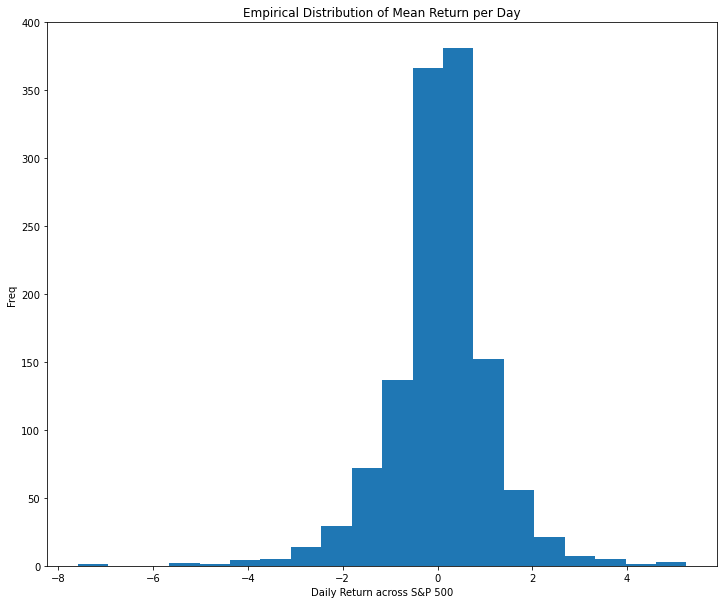

In [4]:
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.hist(train_data.mean(axis=1),bins=20)
plt.title("Empirical Distribution of Mean Return per Day")
plt.xlabel("Daily Return across S&P 500")
plt.ylabel("Freq")

Text(0.5, 1.0, 'Singular Values of Covariance Matrix')

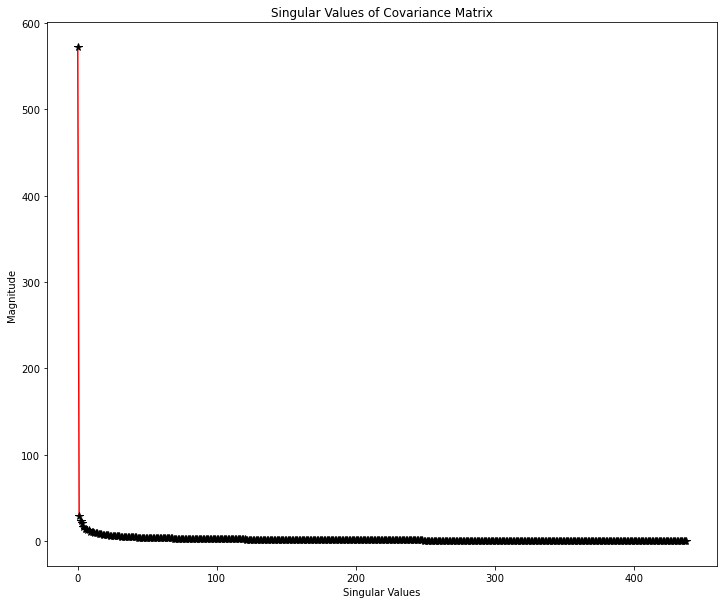

In [5]:
u,s,v=np.linalg.svd(returns_cov)
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.plot(s,marker='*',color='red',markersize=7.5,mfc='black',mec='black')
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title("Singular Values of Covariance Matrix")

### Regularized Mean and Covariance Estimators 

In [6]:
biased_mean=reg_mean(train_data,train_data.shape[0])

biased_cov=reg_cov(train_data)

### Application of Sparse Solver Split Bregman Operator

Utilizes nested optimization routine where
- Inner Optimization is unconstrained QP problem involving L2 penalty
    - Can solve numerically via constrained minimization and box constraints
    - Solve analytically via closed form solution
- Applies shrinkage (L1) penalty within outer loop


Interesting results in normalization of w vector

In [7]:
def qp(cov,mean,w,d,b,lb,ub,lambda2,approach,tol=10e-6,maxiter=25,verbose=True):
    """ Inner optimization problem using unconstrained optimization 
        Approach "numerical" solves numerically via unconstrained minimization
        Approach "closed-form" solves analytically via cvxopt within qpsolvers 
        Support for standard mean variance optimization (approach=2; pen=False)
    """
    
 
    x0=w
    status=None

    if approach=="numerical":
        
        # define objective function
        def objective_val(w,cov,mean,d,b,lambda2):
            obj=np.dot(np.dot(w,cov+lambda2*np.diag(d-b)),w)-np.dot(w,mean)
            return obj
        
        # define bounds and constraints
        bounds=Bounds(lb,ub)
        lc=LinearConstraint(np.ones(len(mean)),1,1)

        # solve unconstrained optimization problem
        try:
            res=minimize(objective_val,x0=x0,args=(cov,mean,d,b,lambda2),method='SLSQP',bounds=bounds,constraints=lc,options={'maxiter':maxiter},tol=tol)
        except Exception as e:
            print(e)
            status="failed"
            return w,status
        # check if optimization was successful
        w=res.x
        status=res.status
        
    if approach=="closed-form":
        
        w_old=w
        # define objective function
        quad=csc_matrix((cov+lambda2*np.diag(d-b)),shape=(len(mean),len(mean)))
        linear=-1*mean
        
        # constrain solution vector to be unit norm and non-negative
        A=np.ones(len(mean))
        constraint=np.array([1.0])

        # set box constraints
        lb_vec=lb*np.ones(len(mean))
        ub_vec=ub*np.ones(len(mean))

        #solve qp problem
        try:
            w = solve_qp(quad,linear,A=A,b=constraint,lb=lb_vec,ub=ub_vec,initvals=x0, solver="cvxopt")
        except Exception as e:
            print(e)
            status="failed"
            return w_old,status
        status="solved"

        if w is None:
            print("QP Optimization fails, Trying again")
            status="failed"
            return w_old,status
    return w,status

def shrinkage(w,b,lambda1,beta):
    """ Applies one-sided soft-thresholding operator that is equivalent to L1 penalization 
    """
    
    if lambda1==0:
        return np.zeros(len(w))
    x=beta*w+b
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,lambda1,lambda2,lb,ub,beta=None,tol=1e-5,maxiter=100,approach=2,verbose=True):
    """ Split Bregman Optimization Routine
    """

    total_cost=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.random.rand(n)
    w=w/np.linalg.norm(w,ord=1)
    d=np.zeros(n)
    
    i=0
    while (total_cost)>tol:
        if i>maxiter:
            if verbose:
                print("MaxIter Achieved")
            break
        
        # solve qp problem either closed form or numerically
        w,status=qp(cov,mean,w,d,b,lb,ub,lambda2,approach,tol,maxiter,verbose)
        
        if status=="failed":
            break
            
 
        # solve for sparse vector near previous optimal solution
        d=shrinkage(w,b,lambda1,beta)
        b=b+beta*w -d 
        i+=1

        # compute total cost
        total_cost=np.dot(np.dot(w,cov),w)-np.dot(w,mean)+(lambda1*np.sum(np.abs(w))+lambda2*np.sum((w)**2))/2
        if verbose:
            print(f"Total Cost: {total_cost}")
        
        # additional normalization
        if 1-np.sum(abs(w))>tol:
            w=w/np.sum(abs(w))
            
    return w, total_cost,status

### Numerical Results

Unit Tests
- Solve for the optimal solution both via closed form solution and numerically via minimization 
- Compare optimal objective values and solution


### Test 1: Equal Penalties Closed Form and Numerically

In [8]:
lambda1=10e-2
lambda2=10e-4
w_numerical,error_numerical,status=split_bregman(biased_cov,biased_mean,lb=-1,ub=1,lambda1=lambda1,lambda2=lambda2,tol=1e-6,maxiter=25,approach="numerical",verbose=True)
w_numerical

Total Cost: 0.1722769305937411
Total Cost: 0.17230364217464805
Total Cost: 0.17233211621883454
Total Cost: 0.1723150177029652
Total Cost: 0.17233512340836238
Total Cost: 0.17232188158292075
Total Cost: 0.17232188158292075
Total Cost: 0.17232188158292075
Total Cost: 0.17232188158292075
Total Cost: 0.17232188158292075
Total Cost: 0.17232188158292075
Total Cost: 0.17232188158292075
Total Cost: 0.17232188158292075
Total Cost: 0.17232188158292075
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
Total Cost: 0.17233797981634735
MaxIter Achieved


array([ 8.25308284e-03,  6.88040923e-03,  9.49849264e-03, -1.12857287e-03,
        4.74222270e-03,  4.29661916e-03, -6.58797254e-03, -1.07879434e-03,
        6.22614111e-03,  8.87119467e-03, -1.68310599e-02, -1.17984190e-02,
       -9.30759988e-03,  2.44179427e-03, -2.11082791e-03,  7.95507790e-04,
       -6.86651507e-03, -1.01614806e-02, -8.86481846e-04,  1.76019320e-03,
        7.17975526e-03,  1.05566619e-03,  1.12595692e-03,  2.39828334e-02,
       -1.67036552e-03, -9.37841296e-03, -3.16833833e-03,  1.00040330e-03,
        5.36008968e-03, -5.36440389e-03, -4.28539904e-03,  2.79204302e-04,
        1.85947425e-02, -4.32427844e-03,  1.68227775e-02,  8.90115825e-04,
       -1.94030370e-03, -3.44737645e-03,  5.80334417e-04,  5.12008493e-04,
        8.01579519e-03, -6.54521275e-03,  1.87315079e-02, -2.13053326e-04,
        3.27586321e-02,  9.47657690e-03,  5.21966113e-03,  9.86208037e-03,
        3.85373388e-04, -5.42374038e-03,  3.99219317e-02,  5.77425194e-03,
       -4.20814241e-03, -

In [9]:
lambda1=10e-2
lambda2=10e-4
w_cf,error_cf,status=split_bregman(biased_cov,biased_mean,lb=-1,ub=1,lambda1=lambda1,lambda2=lambda2,tol=1e-6,maxiter=25,approach="closed-form",verbose=True)
w_cf

Total Cost: 0.26102956085174567
Total Cost: 0.26103042503502194
Total Cost: 0.26103128929642444
Total Cost: 0.26103215363656534
Total Cost: 0.2610330180554591
Total Cost: 0.26103388255312
Total Cost: 0.2610347471295623
Total Cost: 0.2610356117848003
Total Cost: 0.26103647651884854
Total Cost: 0.2610373413317214
Total Cost: 0.2610382062234331
Total Cost: 0.26103907119399794
Total Cost: 0.26103993624343047
Total Cost: 0.2610408013717449
Total Cost: 0.26104166657895567
Total Cost: 0.2610425318650774
Total Cost: 0.26104339723012393
Total Cost: 0.2610442626741101
Total Cost: 0.2610451281970504
Total Cost: 0.26104599379895865
Total Cost: 0.26104685947984985
Total Cost: 0.26104772523973807
Total Cost: 0.261048591078638
Total Cost: 0.2610494569965638
Total Cost: 0.26105032299352987
Total Cost: 0.2610511890695507
MaxIter Achieved


array([ 1.12720459e-02,  1.28649530e-02,  5.36962095e-03,  4.09703798e-04,
        7.00674327e-03,  2.48088267e-03, -8.14845817e-03, -3.01707045e-03,
        9.67201901e-03,  1.19835991e-02, -2.38663294e-02, -1.61148578e-02,
       -1.15806189e-02,  1.16162965e-03, -1.94824154e-03,  6.62484839e-03,
       -1.10487811e-02, -1.66313656e-02, -2.79031790e-04,  6.92182893e-03,
        1.24037832e-02, -3.05093763e-03, -3.14942007e-03,  3.55897576e-02,
       -4.63263815e-03, -1.70065995e-02, -3.64707626e-03,  3.98809101e-03,
        8.70837933e-03, -5.17470634e-03, -4.99616076e-03,  7.84754627e-05,
        2.44000333e-02,  5.34181853e-04,  2.53891991e-02,  4.84991508e-03,
       -2.11531413e-04, -1.34897976e-03, -1.32793892e-03, -3.08147950e-03,
        1.16458904e-02, -1.54328493e-02,  2.65425138e-02, -1.51774337e-03,
        4.03670699e-02,  5.67403870e-03,  8.78398583e-03, -1.68324646e-03,
        6.29241269e-05, -6.28205101e-03,  5.24008769e-02,  7.17044359e-03,
       -8.86040206e-03, -

### Comparisons of Optimal Solution

In [10]:
cutoff_threshold=0.001

Text(0, 0.5, 'Weight Allocation')

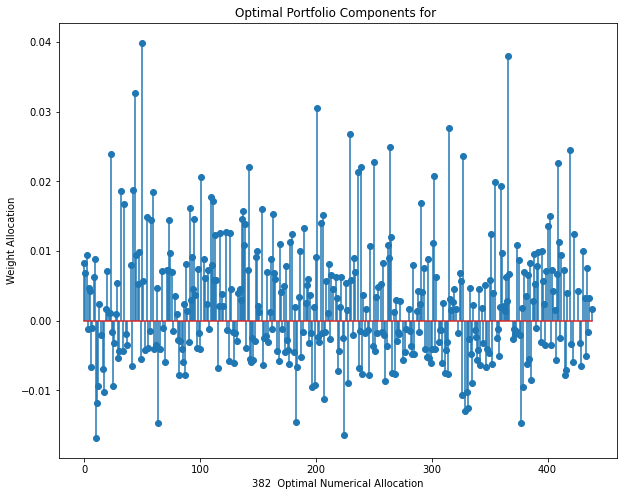

In [11]:
optimal_numerical=np.where(abs(w_numerical)>cutoff_threshold)[0]
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Optimal Portfolio Components for ")
ax.stem(optimal_numerical,w_numerical[optimal_numerical],markerfmt='o',use_line_collection=True)
ax.set_xlabel(f"{len(optimal_numerical)}  Optimal Numerical Allocation")
ax.set_ylabel("Weight Allocation")

Text(0, 0.5, 'Weight Allocation')

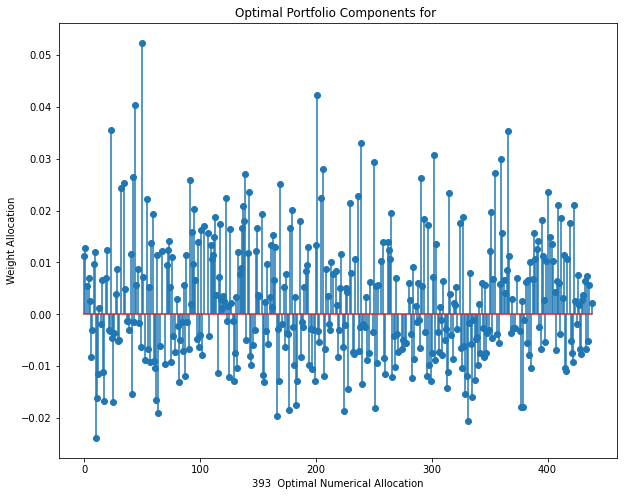

In [12]:
optimal_cf=np.where(abs(w_cf)>cutoff_threshold)[0]
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Optimal Portfolio Components for ")
ax.stem(optimal_cf,w_cf[optimal_cf],markerfmt='o',use_line_collection=True)
ax.set_xlabel(f"{len(optimal_cf)}  Optimal Numerical Allocation")
ax.set_ylabel("Weight Allocation")

### Grid Search for Optimal Lambda Values 
- Cross valaidate optimal $\lambda_1$ and $\lambda_2$ parameters representing L1 and L2 regularization

In [13]:
def grid_search(params,returns_mean,returns_cov,tol=1e-8,maxiter=25):
    """ Grid Search for optimal lambda1 and lambda2 under constrained portfolio problem 
    """
    results={}
    for i in params:
        lambda1,lambda2=i
        lb,ub=-1,1
        w,error,status=split_bregman(returns_cov,returns_mean,lambda1,lambda2,lb=lb,ub=ub,tol=tol,maxiter=maxiter,approach="closed-form",verbose=False)
        if status=="failed":
            print(f" Closed Form Optimization Failed for lambda1: {lambda1} and lambda2: {lambda2}")
            continue
        print(f" lambda1: {np.round(lambda1,8)} lambda2: {np.round(lambda2,8)} error: {np.round(error,8)}")
        results[i]=(w,error)
    sorted_dict=sorted(results.items(), key=lambda x:x[1][1])
    return sorted_dict

# define grid search parameters
lambda1_grid=np.geomspace(10e-6,1,5)
lambda2_grid=np.geomspace(10e-6,1,5)

# take all possible combinations of lambda1 and lambda2
params=[]
for i in itertools.product(lambda1_grid,lambda2_grid):
    params.append(i)

sorted_dict=grid_search(params,biased_mean,biased_cov)

 lambda1: 1e-05 lambda2: 1e-05 error: 0.07042509
 lambda1: 1e-05 lambda2: 0.00017783 error: 0.07043155
 lambda1: 1e-05 lambda2: 0.00316228 error: 0.0705467
 lambda1: 1e-05 lambda2: 0.05623413 error: 0.07269067
QP Optimization fails, Trying again
 Closed Form Optimization Failed for lambda1: 1e-05 and lambda2: 1.0
 lambda1: 0.00017783 lambda2: 1e-05 error: 0.07074496
 lambda1: 0.00017783 lambda2: 0.00017783 error: 0.07075143
 lambda1: 0.00017783 lambda2: 0.00316228 error: 0.07086663
 lambda1: 0.00017783 lambda2: 0.05623413 error: 0.07301176
QP Optimization fails, Trying again
 Closed Form Optimization Failed for lambda1: 0.00017782794100389227 and lambda2: 1.0
 lambda1: 0.00316228 lambda2: 1e-05 error: 0.07643318
 lambda1: 0.00316228 lambda2: 0.00017783 error: 0.0764397
 lambda1: 0.00316228 lambda2: 0.00316228 error: 0.07655598
 lambda1: 0.00316228 lambda2: 0.05623413 error: 0.0787218
QP Optimization fails, Trying again
 Closed Form Optimization Failed for lambda1: 0.0031622776601683794

Optimal lambda1: 1e-05 Optimal lambda2: 1e-05 with error: 0.07042509116883862


Text(0, 0.5, 'Weight Allocation')

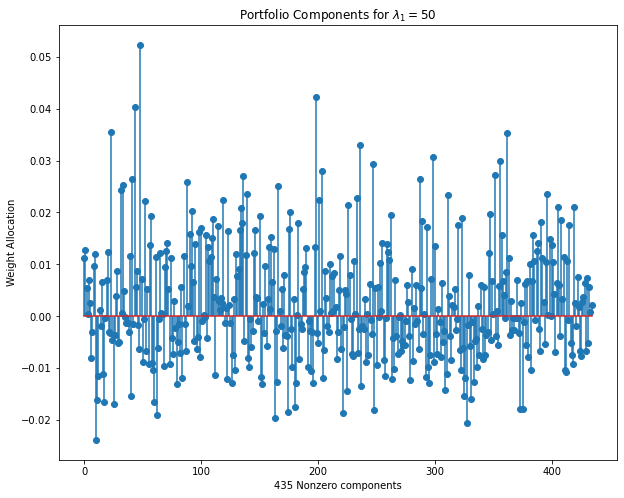

In [14]:
wi=sorted_dict[0][1][0]
print(f"Optimal lambda1: {sorted_dict[0][0][0]} Optimal lambda2: {sorted_dict[0][0][1]} with error: {sorted_dict[0][1][1]}")
nonzero_wi=np.where(abs(wi)>0.0001)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=50$")
ax.stem(wi[nonzero_wi])
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")

In [15]:
print(f"Largest Component is {max(abs(wi[nonzero_wi]))}")
print(f"Smallest Component is {min(abs(wi[nonzero_wi]))}")

Largest Component is 0.05235377534344419
Smallest Component is 0.0001046160408605717
